In [ ]:
!pip install kaggle


In [ ]:
import os
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
kaggle_config = json.load(open('kaggle.json'))


In [ ]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [ ]:
 #!/bin/bash
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
  0% 0.00/20.7M [00:00<?, ?B/s]
100% 20.7M/20.7M [00:00<00:00, 1.08GB/s]


In [ ]:
!ls

kaggle.json  sample_data  spotify-million-song-dataset.zip


In [ ]:
with zipfile.ZipFile('spotify-million-song-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
df=pd.read_csv('/content/spotify_millsongdata.csv')

In [ ]:
df.shape

(57650, 4)

In [ ]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [ ]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [ ]:
 top_artists = df['artist'].value_counts().head(10)
 print(top_artists)

artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [ ]:
df = df.sample(10000)
df = df.drop('link',axis=1).reset_index(drop=True)


In [ ]:
df.head()

,artist,song,text
0,INXS,Spy Of Love,Have you noticed to this day \r\nHow many tim...
1,Cheap Trick,You Let A Lotta People Down,So how does it feel \r\nTo stand so close \r...
2,Don McLean,Your Cheatin' Heart,Your cheatin' heart will make you weep \r\nYo...
3,Morrissey,Hold On To Your Friends,A bond of trust \r\nHas been abused \r\nSome...
4,Z-Ro,Fuck All Yal,"[Z-Ro:] \r\nAin't nobody, really got my back ..."


In [ ]:
df.shape

(10000, 3)

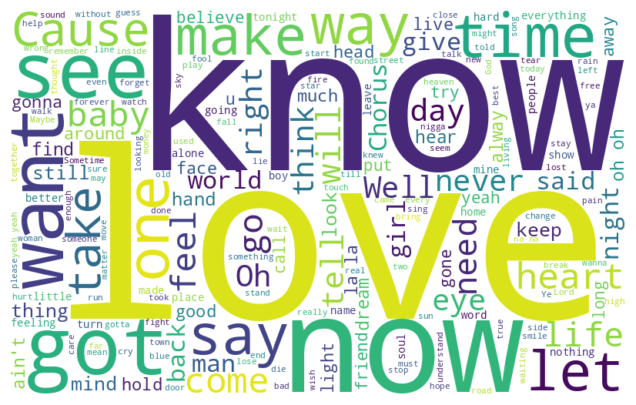

In [ ]:
all_lyrics = " ".join(df['text'].dropna())
wordcloud=WordCloud(width=800,height=500,background_color='white').generate(all_lyrics)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
  stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
  text = re.sub(r'[^a-zA-Z\s]', ' ', text)
  text=text.lower()
  tokens=word_tokenize(text)
  tokens=[word for word in tokens if word not in stop_words]
  return " ".join(tokens)

In [ ]:
 df['cleaned_text']=df['text'].apply(preprocess_text)

In [ ]:
df.head()

,artist,song,text,cleaned_text
0,INXS,Spy Of Love,Have you noticed to this day \r\nHow many tim...,noticed day many times prayed played lifting l...
1,Cheap Trick,You Let A Lotta People Down,So how does it feel \r\nTo stand so close \r...,feel stand close never understand feel mean mu...
2,Don McLean,Your Cheatin' Heart,Your cheatin' heart will make you weep \r\nYo...,cheatin heart make weep try try try sleep slee...
3,Morrissey,Hold On To Your Friends,A bond of trust \r\nHas been abused \r\nSome...,bond trust abused something value may lost giv...
4,Z-Ro,Fuck All Yal,"[Z-Ro:] \r\nAin't nobody, really got my back ...",z ro nobody really got back motherfuckers hang...


In [ ]:
 tfidf_vectorizer = TfidfVectorizer(max_features=5000)
 tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [ ]:
cosine_sim=cosine_similarity(tfidf_matrix,tfidf_matrix)

In [ ]:
def recommend_songs(song_name, cosine_sim=cosine_sim,df=df,top_n=5):
  idx=df[df['song'].str.lower()==song_name.lower()].index
  if len(idx)==0:
    return "song not available"
  idx=idx[0]
  sim_scores=list(enumerate(cosine_sim[idx]))
  sim_scores=sorted(sim_scores,key=lambda x:x[1],reverse=True)
  sim_scores=sim_scores[1:top_n+1]

  song_indices=[i[0] for i in sim_scores]

  return df[['artist','song']].iloc[song_indices]

In [ ]:
df["song"][3]

'Hold On To Your Friends'

In [ ]:
print("recommendation0")
rec=recommend_songs("Cheap Thrills")
print(rec)

recommendation0
              artist                 song
5002       Offspring          Bloodstains
1622   Frank Sinatra               Brazil
9068     Norah Jones  The Nearness Of You
6460      Katy Perry              Hook Up
1849  Kelly Clarkson     I Do Not Hook Up
